# Import essential libraries

In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


# Load and show dataset

In [14]:
columns = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

columns += [f"Wilderness_Area{i}" for i in range(1, 5)]

columns += [f"Soil_Type{i}" for i in range(1, 41)]

columns += ["Cover_Type"]


df = pd.read_csv("/content/forest_dataset.csv", header=None, names=columns)
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
1,2683,333,35,30,26,2743,121,173,179,6572,...,0,0,0,0,0,0,0,0,0,2
2,2915,90,8,216,11,4433,232,228,129,4019,...,0,0,0,0,0,0,0,0,0,1
3,2941,162,7,698,76,2783,227,242,148,1784,...,0,0,0,0,0,0,0,0,0,2
4,3096,60,17,170,3,3303,231,202,99,5370,...,0,0,0,0,0,0,0,0,0,1


# Data Exploration

(10001, 55)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           10001 non-null  int64
 1   Aspect                              10001 non-null  int64
 2   Slope                               10001 non-null  int64
 3   Horizontal_Distance_To_Hydrology    10001 non-null  int64
 4   Vertical_Distance_To_Hydrology      10001 non-null  int64
 5   Horizontal_Distance_To_Roadways     10001 non-null  int64
 6   Hillshade_9am                       10001 non-null  int64
 7   Hillshade_Noon                      10001 non-null  int64
 8   Hillshade_3pm                       10001 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  10001 non-null  int64
 10  Wilderness_Area1                    10001 non-null  int64
 11  Wilderness_Area2                    10001 non-null  int

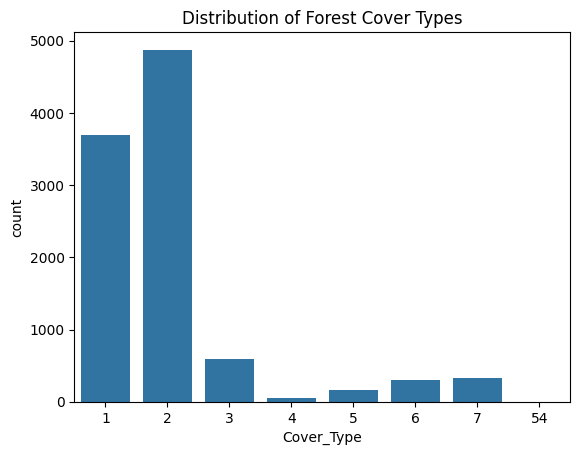

In [15]:


print(df.shape)
print(df.info())

print("Missing values:\n", df.isnull().sum())

sns.countplot(x=df['Cover_Type'])
plt.title("Distribution of Forest Cover Types")
plt.show()


# Split Features & Target

In [17]:
counts = y.value_counts()
rare_classes = counts[counts < 2].index
df = df[~df['Cover_Type'].isin(rare_classes)]

X = df.drop("Cover_Type", axis=1)
y = df["Cover_Type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Train Random Forest

In [18]:

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report
              precision    recall  f1-score   support

           1       0.79      0.78      0.79       738
           2       0.80      0.84      0.82       975
           3       0.73      0.84      0.78       118
           4       1.00      0.40      0.57        10
           5       0.71      0.15      0.25        33
           6       0.78      0.47      0.58        60
           7       0.96      0.76      0.85        66

    accuracy                           0.79      2000
   macro avg       0.82      0.61      0.66      2000
weighted avg       0.79      0.79      0.79      2000




# Train XGBoost

In [21]:
# Shift labels from 1-7 to 0-6 for XGBoost
y_train_enc = y_train - 1
y_test_enc = y_test - 1

xgb_model = xgb.XGBClassifier(
    objective="multi:softmax", num_class=len(np.unique(y_train_enc)),
    eval_metric="mlogloss", use_label_encoder=False
)
xgb_model.fit(X_train, y_train_enc)


y_pred_xgb = xgb_model.predict(X_test)


from sklearn.metrics import classification_report
print("XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb + 1))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:48:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report
              precision    recall  f1-score   support

           1       0.78      0.77      0.78       738
           2       0.80      0.84      0.82       975
           3       0.77      0.82      0.80       118
           4       0.83      0.50      0.62        10
           5       0.75      0.36      0.49        33
           6       0.73      0.60      0.66        60
           7       0.91      0.80      0.85        66

    accuracy                           0.79      2000
   macro avg       0.80      0.67      0.72      2000
weighted avg       0.79      0.79      0.79      2000



# confusion matrix

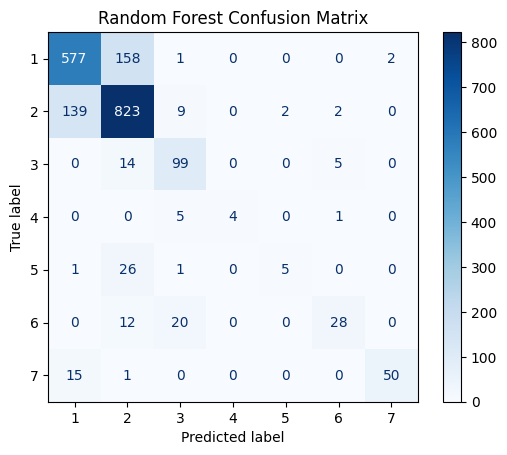

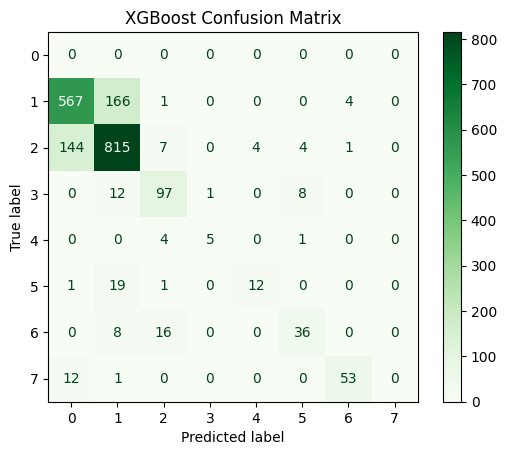

In [24]:
# Random Forest
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

# XGBoos
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, cmap="Greens")
plt.title("XGBoost Confusion Matrix")
plt.show()


# Feature Importance

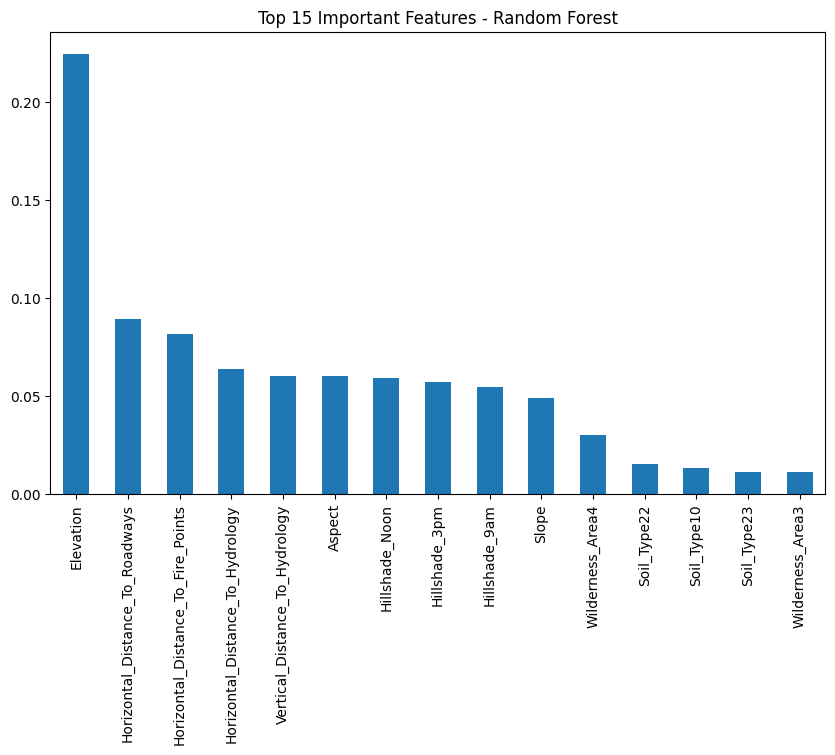

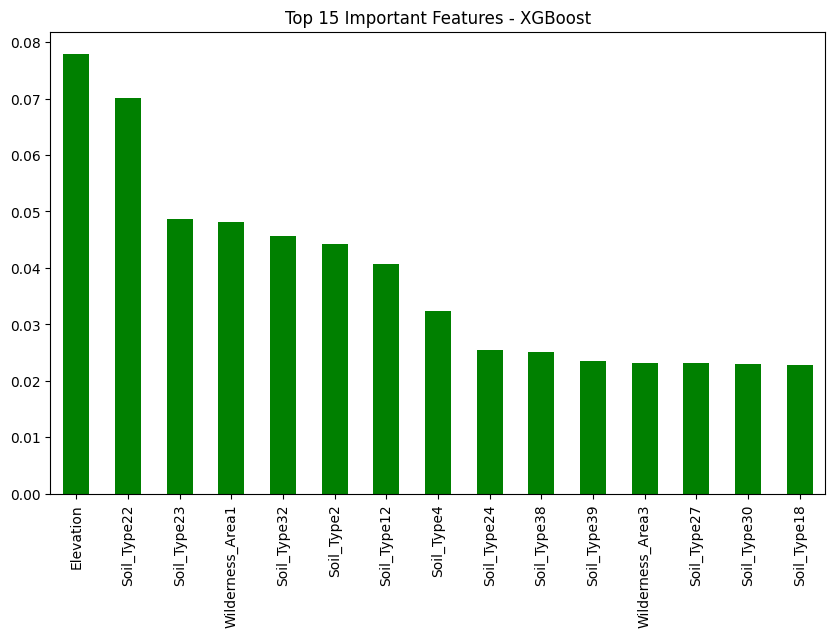

In [25]:
# Feature importance RF
importances_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances_rf[:15].plot(kind="bar")
plt.title("Top 15 Important Features - Random Forest")
plt.show()

# Feature importance XGBoost
importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances_xgb[:15].plot(kind="bar", color="green")
plt.title("Top 15 Important Features - XGBoost")
plt.show()


# (Bonus): Hyperparameter Tuning

In [26]:
# Grid Search for Random Forest
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid, cv=3, n_jobs=-1, verbose=1)

grid_rf.fit(X_train, y_train)

print("Best Parameters for RF:", grid_rf.best_params_)
print("Best Score:", grid_rf.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters for RF: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.7879991182647555
